### Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import multilabel_confusion_matrix
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
#from keras.utils import to_categorical
#from keras.preprocessing import image

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

import PIL
from copy import deepcopy

### Loading in data, train and test sets

In [ ]:
train = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
labels_data = pd.read_csv("data/labels.csv")

In [ ]:
train

### Turning labels column to multiple label columns
Kinda like onehotencoder

In [ ]:
for label in labels_data.label_id:
  column_values = []
  for index, entry in train.iterrows():
    if label in entry.labels.split(" "):
      column_values.append(1)
    else:
      column_values.append(0)
  train[label] = column_values

In [ ]:
train[:5]

In [ ]:
print(train[:1].l16)
print(train[:1].l18)
print(train[:1].l23)
print(train[:1].l25)
print(train[:1].l73)

### Reading in pictures

In [ ]:
pic = image.imread("data/images/img120.jpg")
print(pic.dtype)
print(pic.shape)
plt.imshow(pic)
plt.show()

In [ ]:
imageDir = "data/images/"
images = dict()
for imageName in os.listdir(imageDir):
  pic = image.imread(f"{imageDir}{imageName}")
  images[imageName] = pic

In [ ]:
print(f"CSV files have {len(train) + len(test_data)} entries, but we have {len(images)} images.")

Going through train and test CSV and leaving only image entries that we have picture for.

In [ ]:
train = train[train["image_id"].isin(images.keys())]
train = train.reset_index(drop=True)
test = test_data[test_data["image_id"].isin(images.keys())]
test = test_data.reset_index(drop=True)
print(len(train))
print(len(test_data))

In [ ]:
train

Changing img278.jpg labels, because they are wrong.

In [ ]:
#train.loc[train["image_id"] == "img278.jpg"]
#for label in ["l0", "l12", "l3", "l37", "l38", "l40", "l80"]:
#    train.at[143, label] = 0
# replacing
# for ...
#train.loc[train["image_id"] == "img278.jpg"]

# or just remove it
train.drop(train.loc[train["image_id"] == "img278.jpg"].index, inplace=True)
train.reset_index(drop=True, inplace=True)
train.loc[train["image_id"] == "img278.jpg"]


Adding imagedata to dataframe

In [ ]:
train_images = []
test_images = []
for index, entry in train.iterrows():
  train_images.append(images[entry.image_id])
for index, entry in test.iterrows():
  test_images.append(images[entry.image_id])
train["image_data"] = train_images
test_data["image_data"] = test_images

In [ ]:
train[:5]

In [ ]:
train_X = train.image_data
train_y = train.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

In [ ]:
train_X[0]

In [ ]:
train.labels

In [ ]:
train_y

In [ ]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)

Combining labels #TODO

In [ ]:
combined = {
    "l0": "l0 l8", #people <- person
    "l1": "l1 l27", #trees <- tree
    "l3": "l3 l5", #building <- buildings
    "l4": "l4 l17", #snow <- winter
    
}

Remove labels that are not frequent.

In [ ]:
train_less_labels = train.copy()

Removing onehot-columns

In [ ]:
min_count = 5
for i in range(92):
    label = "l"+str(i)
    count = train_less_labels[label].sum()
    #print(count)
    if count < min_count:
        train_less_labels.drop(label, inplace=True, axis=1)

Fixing labels colummn values

In [ ]:
remaining = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10', 'l11', 'l12', 'l13', 'l14', 'l15', 'l17', 'l18', 'l19', 'l20', 'l21']
len(remaining)

for i in range(len(train_less_labels)):
    new_values = " ".join([x for x in train_less_labels.iloc[i].labels.split(" ") if x in remaining])
    
    if i == 143:
        print(train_less_labels.iloc[i].labels)
        print(new_values)
    train_less_labels.iloc[i, 1] = new_values
    #train_fastai.loc[i, ["labels"]] = "a"

Removing rows where "labels" is empty

In [ ]:
to_drop = []
for i, label in enumerate(train_less_labels.labels):
    if label == "":
        to_drop.append(i)
print(to_drop)
# img217
train_less_labels.drop(train_less_labels.index[to_drop], inplace=True)

In [ ]:
train_less_labels.reset_index(drop=True, inplace=True)
train_less_labels.head(20)

In [ ]:
train_X = train_less_labels.image_data
train_y = train_less_labels.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

In [ ]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)


In [ ]:
# remove some l0 and l1 images
#l0_indexes = []
#l1_indexes = []

#for index, row in train.iterrows():
#    if "l0" in row.labels and len(l0_indexes) < 40:
#        l0_indexes.append(index)
#    elif "l1" in row.labels and len(l1_indexes) < 40:
#        l1_indexes.append(index)

#print(len(l0_indexes))
#print(len(l1_indexes))

#to_remove = list(set(l0_indexes + l1_indexes))
#train_new = train.drop(train.index[to_remove])
#train_new = train_new.reset_index(drop=True)
#print(len(train_new))

In [ ]:
What if we just oversample images with low label counts.

In [ ]:
train_oversample = train.copy()

In [ ]:
to_oversample = []
for index, row in train_oversample.iterrows():
    if not any(label in row.labels for label in ["l0", "l1", "l2", "l3", "l4", "l8"]):
        to_oversample.append(row)

print(len(to_oversample))
for row in to_oversample:
    for _ in range(20):
        train_oversample = pd.concat([train_oversample, row.to_frame().T])

In [ ]:
#train_oversample.tail(3)

In [ ]:
train_X = train_oversample.image_data
train_y = train_oversample.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

In [ ]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)

There are not many pictures that don't have popular labels.

Oversampling by ratios

In [ ]:
# trying https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification/notebook
label_counts = {}
count_sum = 0
for i in range(92):
    label = "l"+str(i)
    count = 0
    for labels in train["labels"]:
        if label in labels:
            count += 1
    label_counts[label] = count
    count_sum += count
label_counts["avg"] = int(count_sum/92)

def oversample_ratio(x):
    label_count = int(x)
    if label_count < label_counts["avg"]:
        return int(round(label_counts["avg"] / label_count))
    else: return 1

count_df = list(zip(label_counts.keys(), label_counts.values()))
count_df = np.array(sorted(count_df, key=lambda x:-x[1]))
count_df = pd.DataFrame(count_df, columns=["label", "full_count"])
count_df.set_index("label", inplace=True)
count_df["oversampling_ratio"] = count_df["full_count"].apply(oversample_ratio)
count_df.T

In [ ]:
def highest_ratio(row):
    ratio = 1
    labels = row[1].split(" ")
    for label in labels:
        r = count_df.oversampling_ratio.loc[label]
        if r > ratio: ratio = r
    return ratio

def lowest_ratio(row):
    ratio = 1000
    labels = row[1].split(" ")
    for label in labels:
        r = count_df.oversampling_ratio.loc[label]
        if r < ratio: ratio = r
    return ratio

#train_os_w_ratios = train.copy()

rows = train.values.tolist()
print(len(rows))
oversampled_rows = [row for row in rows for _ in range(highest_ratio(row))]
print(len(oversampled_rows))

train_os_w_ratios = pd.DataFrame(oversampled_rows, columns=train.columns)
train_os_w_ratios.head(2)

In [ ]:
train_X = train_os_w_ratios.image_data
train_y = train_os_w_ratios.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

In [ ]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)

Just checking

img198 l0 l10 l11 l65 l7

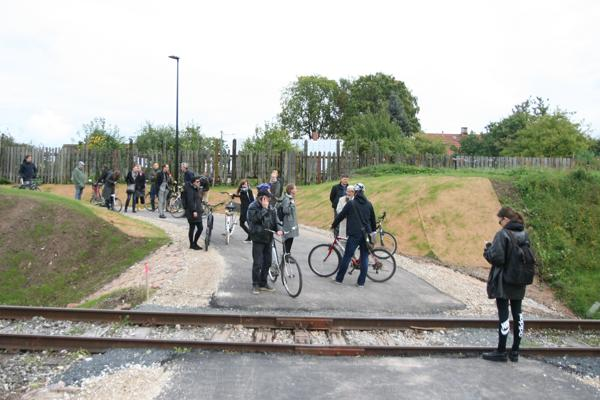

In [ ]:
img198labels = train_y.iloc[[129]]
img198labels.columns[img198labels.iloc[0]==1]

In [ ]:
print(type(train_X.iloc[[178][0]]))
plt.imshow(train_X.iloc[[178][0]])
plt.show()

In [ ]:
print(f"Loaded in {len(train_X), len(train_y)} train images and {len(test_X)} test images.")
print(f"Total: {len(train_X) + len(test_X)}")

In [ ]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
# "Names" of classes:
class_names = ['l0','l9','l4','l15','l13']
readable_names = {"l0":"people", "l9":"cars", "l4":"snow", "l15":"lamp posts", "l13":"building"}
num_classes = len(class_names)

samples_per_class = 3 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(train_y[cls])
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx], plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(readable_names[cls])
plt.show()

### How to process images?

Images have different sizes

In [ ]:
min_width = 5000
max_width = 0
min_height = 5000
max_height = 0
widths = []
heights = []
for i in range(len(train_X)):
  h, w, c = train_X.iloc[i].shape
  widths.append(w)
  heights.append(h)
  #print(h, w, c)
  if h > max_height:
    max_height = h
  elif h < min_height:
    min_height = h
  elif w > max_width:
    max_width = w
  elif w < min_width:
    min_width = w
print("min w-h", min_width, min_height)
print("max w-h", max_width, max_height)
print(f"Avg w {sum(widths) / len(widths)} and h {sum(heights) / len(heights)}.")

In [ ]:
a = np.array([[2,3],[4,4], [2,3]])
a.shape
train_X.iloc[0].shape

In [ ]:
img = PIL.Image.fromarray(train_X[0])
img

In [ ]:
a = deepcopy(train_X[0])
h_centre = int(train_X[0].shape[0] / 2)
w_centre = int(train_X[0].shape[1] / 2)
print(w_centre, h_centre)
ab = a[w_centre-200:w_centre + 200, h_centre - 142:h_centre + 142]
im = PIL.Image.fromarray(ab)
im

Cropping all images to the smallest image size loses a lot of information.

Resizing to avg.

In [ ]:
im = PIL.Image.fromarray(train_X[0])
img_resized = im.resize((572, 432))
img_resized

In [ ]:
im = PIL.Image.fromarray(train_X[0])
img_resized = im.resize((572, 432), PIL.Image.LANCZOS)
img_resized

In [ ]:
im = PIL.Image.fromarray(train_X[0])
img_resized = im.resize((572, 432), PIL.Image.BICUBIC)
img_resized

In [ ]:
train_X_resized = []
for i in range(len(train_X)):
  im = PIL.Image.fromarray(train_X.iloc[i])
  img_resized = im.resize((572, 432), PIL.Image.BICUBIC)
  # to grayscale
  #img_grayscaled = img_resized.convert("L")
  train_X_resized.append(np.array(img_resized))

In [ ]:
train_X_resized = np.array(train_X_resized)
im = PIL.Image.fromarray(train_X_resized[0])
im

In [ ]:
train_X_normalized = train_X_resized / 255
train_X_normalized.shape

In [ ]:
#train_X_reshaped = train_X_normalized.reshape(-1, 432, 572, 1)
#train_X_reshaped[0].shape

### Models

In [ ]:
train_y_np = train_y.to_numpy("float64")
train_y_np.dtype

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X_normalized, train_y, random_state=42, test_size=0.2)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(432, 572, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(21, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

In [ ]:
# Loss and accuracy on test set
model.evaluate(X_test, y_test)

In [ ]:
preds = model.predict(X_test)
#multilabel_confusion_matrix(y_test, y_pred)
preds

In [ ]:
# get top 3 preds
import heapq
cols = train_y.columns.tolist()
as_dataframe = pd.DataFrame(preds, columns = train_y.columns.tolist())
min_treshold = 0.10
row_results = []

for index, row in as_dataframe.iterrows():
    res = []
    col = 0
    values = row.to_numpy()
    top3 = np.argpartition(values, -3)[-3:]
    top3 = np.flip(top3[np.argsort(values[top3])])
    
    for top in top3:
        if values[top] >= min_treshold:
            res.append(cols[top])
    row_results.append(res)
    #print(res)
print(row_results)


# FastAI

In [ ]:
!pip install fastai==1.0.61

In [ ]:
!pip install fastai --upgrade

In [ ]:
from fastai.vision.all import *

In [ ]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
block = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_x=ColReader(0, pref="./data/images/"),
                 splitter=RandomSplitter(),
                 get_y=ColReader(1, label_delim=" "),
                 batch_tfms = batch_tfms)

In [ ]:
block = block.new(item_tfms=Resize(400, ResizeMethod.Pad, pad_mode="zeros"))

In [ ]:
dls = block.dataloaders(train_less_labels)

In [ ]:
dls.show_batch(max_n=9, figsize=(10, 10))

In [ ]:
from torchvision.models import resnet34

In [ ]:
from fastai.metrics import accuracy_multi

In [ ]:
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
learn.loss_func = BCEWithLogitsLossFlat()

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3, lr/5))

In [ ]:
learn.show_results(figsize=(15,15))

In [ ]:
learn.save('stage-2')

img288 missing, img285 missing

In [ ]:
#batch_tfms = aug_transforms(size=300)
block = DataBlock(blocks=(ImageBlock),
                 get_x=ColReader(0, pref="./data/images/"))
block = block.new(item_tfms=Resize(400, ResizeMethod.Pad, pad_mode="zeros"))
dls = block.dataloaders(test_data)
dls.show_batch(max_n=9, figsize=(10, 10))


In [ ]:
#dl = learn.dls.test_dl(test_data, bs=64)
#preds, _ = learn.get_preds(dl= dls)
print(learn.dls.vocab)
print(learn.dls.c)
min_probability = 0.79
filenames = []
predictions = []
for image_name in test_data["image_id"]:
    #print(image_name)
    pred = learn.predict("./data/images/"+image_name)
    #print(pred)
    pred_labels = pred[0]
    preds = pred[2]
    ind = np.argpartition(preds, -5)[-5:]
    #print(ind)
    ind = ind.tolist()
    best_preds_labels = learn.dls.vocab[ind]
    #print(best_preds_labels)
    probabilities = preds[ind]
    #print(probabilities)
    final_labels = []
    for i, proba in enumerate(probabilities):
        if proba > min_probability:
            final_labels.append(best_preds[i])
    #print(final_labels)
    final_labels.reverse()
    #print(final_labels)
    
    #print("CSVsse", image_name, " ".join(final_labels))
    filenames.append(image_name)
    predictions.append(" ".join(final_labels))
    #print(len(preds), len(pred_labels))

In [ ]:
print(filenames)
print(predictions)

In [ ]:
d = {"image_id": filenames, "labels": predictions}
df = pd.DataFrame(d, columns=["image_id", "labels"])

In [ ]:
df

In [ ]:
df.to_csv("submission.csv", index=False)

https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification/notebook

In [ ]:
# item_tfms = RandomResizedCrop(1000, min_scale=0.75, ratio=(1.,1.)) - original
item_tfms = Resize(500, ResizeMethod.Pad, pad_mode="zeros") #Resize(400, ResizeMethod.Pad, pad_mode="zeros")
batch_tfms = [*aug_transforms(max_warp=0, max_rotate=0, max_lighting=0.1)] # add normalize?

In [ ]:
labels = ["l"+str(i) for i in range(92)]
#first 5 FastAI: splitter = RandomSplitter()
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab=labels)),
                   splitter=RandomSplitter(), # TrainTestSplitter(),
                   get_x=ColReader(0, pref="./data/images/"),
                   get_y=ColReader(1, label_delim=" "),
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms,
                   )
bs=32
dls = dblock.dataloaders(train_os_w_ratios, bs=bs)

dls.show_batch(max_n=9, figsize=(10, 10))

In [ ]:
epochs = 50
lr = 1e-3
cbs= None
learn = cnn_learner(dls, resnet18, metrics=[accuracy_multi, APScoreMulti(), F1ScoreMulti(average="macro"), 
                                            F1ScoreMulti(average="micro")]).to_fp16()
learn.fine_tune(epochs, base_lr=lr, cbs=cbs)

In [ ]:
learn.save('newFastAI_50epoch_crop1000')

In [ ]:
#dl = learn.dls.test_dl(test_data, bs=64)
#preds, _ = learn.get_preds(dl= dls)
print(learn.dls.vocab)
print(learn.dls.c)
min_probability = 0.0
filenames = []
predictions = []
for image_name in test_data["image_id"]:
    #print(image_name)
    pred = learn.predict("./data/images/"+image_name)
    #print(pred)
    pred_labels = pred[0]
    preds = pred[2]
    ind = np.argpartition(preds, -5)[-5:]
    #print(ind)
    ind = ind.tolist()
    best_preds_labels = learn.dls.vocab[ind]
    #print(best_preds_labels)
    probabilities = preds[ind]
    #print(probabilities)
    final_labels = []
    for i, proba in enumerate(probabilities):
        if proba > min_probability:
            final_labels.append(best_preds_labels[i])
    #print(final_labels)
    final_labels.reverse()
    #print(final_labels)
    
    #print("CSVsse", image_name, " ".join(final_labels))
    filenames.append(image_name)
    predictions.append(" ".join(final_labels))
    #print(len(preds), len(pred_labels))

In [ ]:
for i in range(len(filenames)):
    print(filenames[i], predictions[i])

In [ ]:
d = {"image_id": filenames, "labels": predictions}
df = pd.DataFrame(d, columns=["image_id", "labels"])

In [ ]:
df.to_csv("submission_e50_crop1000_minscale09.csv", index=False)

In [ ]:
d = {"image_id": filenames, "labels": predictions}
df = pd.DataFrame(d, columns=["image_id", "labels"])

In [ ]:
df.to_csv("submission_e50_crop1000_minscale09.csv", index=False)